In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import jax
import numpy as np
from jax import numpy as jnp
from jax.random import PRNGKey
from optax import adam
import pandas
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions

# disable jax JIT
#jax.config.update("jax_disable_jit", True)

import sys
import os

sys.path.append(os.path.abspath(".."))

from scripts.vigamlss import Normal, Gamma, CustomGEV,DataPreperator, DegenerateNormal, FullCovarianceNormal, MeanFieldNormal
from scripts.vigamlss.utils.transformations import TransformationFunctions

2025-01-29 18:45:37.909477: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738172737.925662  578457 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738172737.929540  578457 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
ddbmi_df = pandas.read_csv("../data/dbbmi_data.csv")

Y_data_np = ddbmi_df["bmi"].values
Y_data_jnp = jnp.array(Y_data_np)
X_data_np = ddbmi_df["age"].values
X_data_jnp = jnp.array(X_data_np)

XDesign = DataPreperator(
    "xDesign", X_data_jnp, "pspline", intercept=False, standardize=False, degree=3, num_knots=20
)()
K = XDesign.K

lambda_mu = Gamma("lambda_mu", jnp.array([0.01]), jnp.array([0.01]), 1)
gammas_mu = DegenerateNormal("gammas_mu", K, lambda_mu)
beta_0_mu = Normal("beta_0_mu", jnp.array([0.0]), jnp.array([100.0]), 1)
lambda_scale = Gamma("lambda_scale", jnp.array([0.01]), jnp.array([0.01]), 1)
gammas_scale = DegenerateNormal("gammas_scale", K, lambda_scale)
beta_0_scale = Normal("beta_0_scale", jnp.array([0.0]), jnp.array([100.0]), 1)
y = Gamma("y", beta_0_mu + XDesign @ gammas_mu, beta_0_scale + XDesign @ gammas_scale, responses=Y_data_jnp)
results = y.model.run_svi_optimization(
    optimizer=adam,
    vi_dist=FullCovarianceNormal,
    vi_sample_size=64,
    epochs=100,
    mb_size=32,
    lr=0.01,
    max_norm=5.0,
    clip_min_max_enabled=False,
    zero_nans_enabled=False,
    prng_key=PRNGKey(0),
)

/tmp/ipykernel_545286/1831295793.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


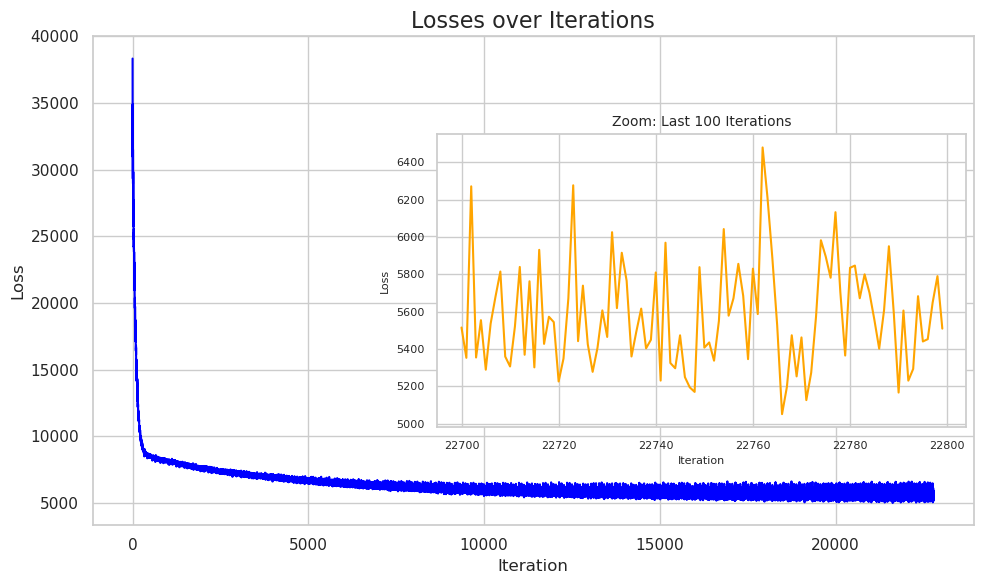

In [3]:
# Data from your results
num_iterations = results["svi_metadata"]["num_iterations"]
losses = results["losses"]

# Create the main plot
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x=range(num_iterations), y=losses, ax=ax, color="blue")

# Add labels and title
ax.set_title("Losses over Iterations", fontsize=16)
ax.set_xlabel("Iteration", fontsize=12)
ax.set_ylabel("Loss", fontsize=12)

# Add inset for zoomed-in view of the last 100 iterations
ax_inset = inset_axes(ax, width="60%", height="60%", loc="center right")
sns.lineplot(
    x=range(num_iterations - 100, num_iterations),
    y=losses[-100:],
    ax=ax_inset,
    color="orange",
)
ax_inset.set_title("Zoom: Last 100 Iterations", fontsize=10)
ax_inset.set_xlabel("Iteration", fontsize=8)
ax_inset.set_ylabel("Loss", fontsize=8)
ax_inset.tick_params(axis="both", which="major", labelsize=8)

# Display the plot
plt.tight_layout()
plt.show()

In [4]:
chol_lower_tril = results["scale_vi_matrix"]
covariance_matrix_jnp = jnp.dot(chol_lower_tril, chol_lower_tril.T)
diagonal = jnp.diag(covariance_matrix_jnp)
diagonal

Array([1.52027817e+02, 4.58034134e+00, 1.74511468e+00, 2.59090376e+00,
       2.71398854e+00, 2.66946340e+00, 2.00581980e+00, 1.54054606e+00,
       1.48730397e+00, 2.30215502e+00, 3.74111867e+00, 4.83570337e+00,
       6.62882996e+00, 8.64892483e+00, 1.03679600e+01, 1.21100349e+01,
       1.45510645e+01, 1.73548069e+01, 1.99816799e+01, 2.20570850e+01,
       2.51887741e+01, 3.08009930e+01, 1.00703359e-01, 3.34476084e-02,
       7.75597095e-02, 6.76150769e-02, 7.85697103e-02, 8.60497504e-02,
       9.22369659e-02, 9.15497392e-02, 7.57868662e-02, 6.60492629e-02,
       6.28356114e-02, 6.43730462e-02, 7.19933882e-02, 7.73398727e-02,
       8.51910710e-02, 8.64583328e-02, 1.04425073e-01, 1.05066933e-01,
       1.35875940e-01, 1.81730196e-01, 3.91349047e-01, 7.96436787e-01,
       5.38579166e-01, 1.16338320e-01], dtype=float32)

<Figure size 1200x700 with 0 Axes>

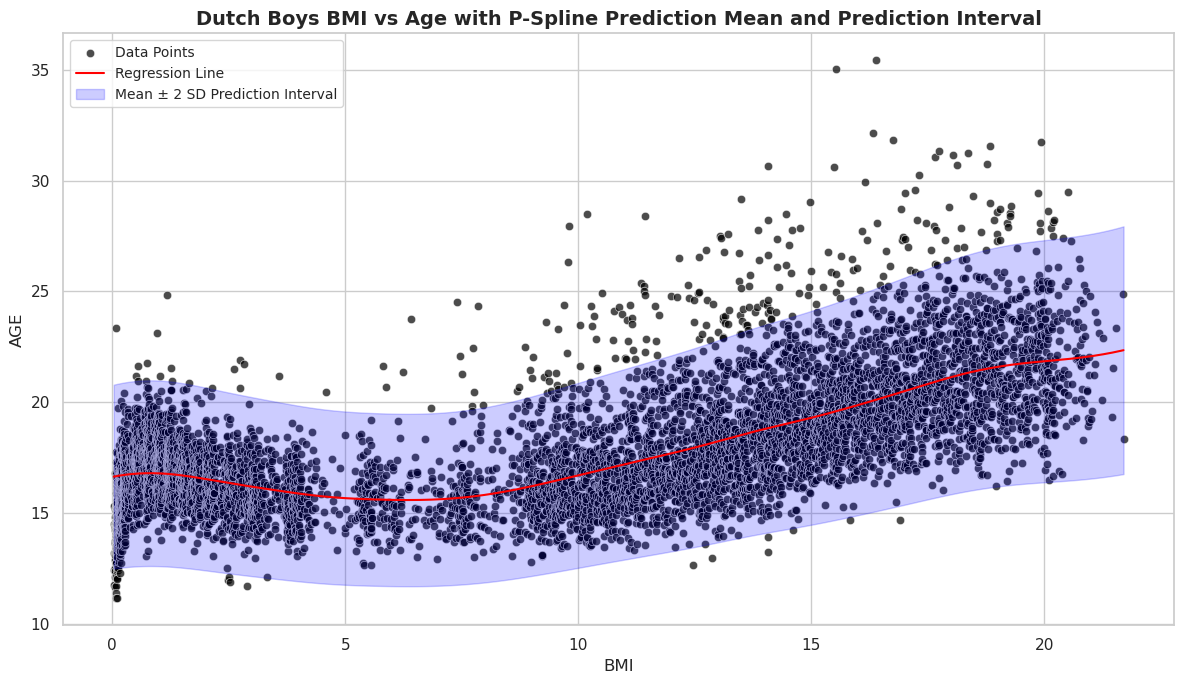

In [5]:
# Response is Gamma Distributed Case
beta_0_mu = results["transformed_loc_vi_parameters"]["beta_0_mu"]
gammas_mu = results["transformed_loc_vi_parameters"]["gammas_mu"]
beta_0_scale = results["transformed_loc_vi_parameters"]["beta_0_scale"]
gammas_scale = results["transformed_loc_vi_parameters"]["gammas_scale"]

X_min, X_max = X_data_jnp.min(), X_data_jnp.max()
X_line = np.linspace(X_min, X_max, 1000)
X_line_design = DataPreperator(
    "xDesign", X_line, "pspline", intercept=False, standardize=False, degree=3, num_knots=20
)()
linear_predictor_concentration = TransformationFunctions.softplus(beta_0_mu + X_line_design.matrix @ gammas_mu)
linear_predictor_rate = TransformationFunctions.softplus(beta_0_scale + X_line_design.matrix @ gammas_scale)

mean_line = linear_predictor_concentration / linear_predictor_rate
variance_line = linear_predictor_concentration / (linear_predictor_rate ** 2)
sd_line = jnp.sqrt(variance_line)

# Set the style and color palette
sns.set_style("whitegrid")
sns.set_palette("deep")

# Create the plot
plt.figure(figsize=(12, 7))
fig, ax = plt.subplots(figsize=(12, 7))

# Plot the data, y axis label is age, a x axis label is bmi
sns.scatterplot(x=X_data_np, y=Y_data_np, color='black', label='Data Points', alpha=0.7, ax=ax)

# Plot the PsSpline regression line
sns.lineplot(x=X_line, y=mean_line, color='red', label='Regression Line', ax=ax)

# Calculate the standard deviation
Y_lower = mean_line - 2 * sd_line
Y_upper = mean_line + 2 * sd_line

# Add the two standard deviation interval
ax.fill_between(X_line, Y_lower, Y_upper, color='blue', alpha=0.2, 
                label='Mean ± 2 SD Prediction Interval')

# Improve the legend
ax.legend(fontsize=10, loc='upper left')

# Customize the plot
ax.set_xlabel('BMI', fontsize=12)
ax.set_ylabel('AGE', fontsize=12)
ax.set_title('Dutch Boys BMI vs Age with P-Spline Prediction Mean and Prediction Interval', fontsize=14, fontweight='bold')

# Adjust the plot margins
plt.tight_layout()

# Show the plot
plt.show()

## GEV

I0000 00:00:1738172770.743611  578457 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1110 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5


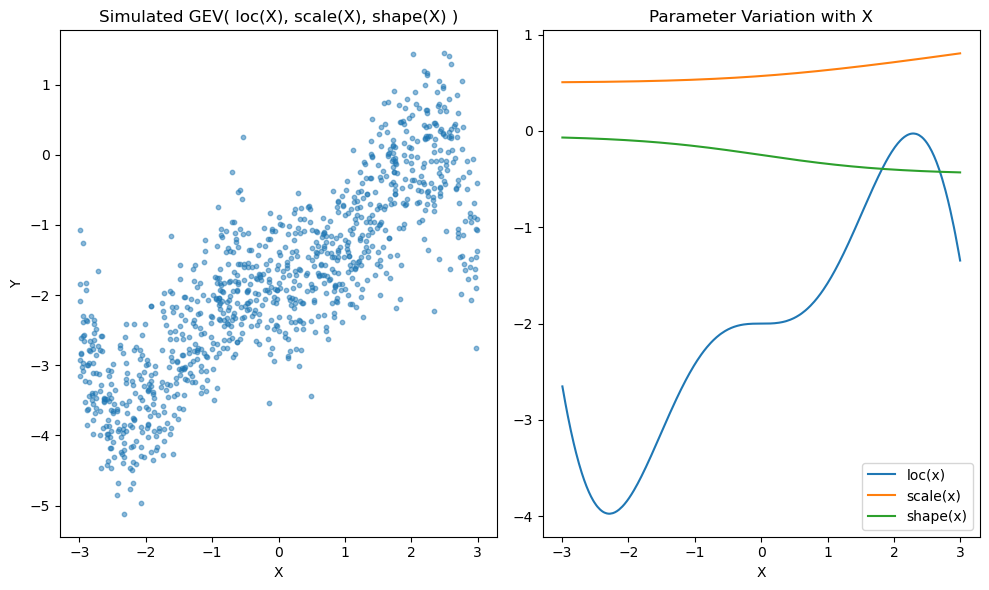

In [3]:
import jax
import jax.numpy as jnp
import tensorflow_probability as tfp
tfd = tfp.distributions
import matplotlib.pyplot as plt

# ------------------------------------------------
# 1) Generate covariate X
# ------------------------------------------------
key = jax.random.PRNGKey(42)
n_samples = 1000
key_x, key_y = jax.random.split(key)
X_GEV = jax.random.uniform(key_x, shape=(n_samples,), minval=-3.0, maxval=3.0)

# ------------------------------------------------
# 2) Define parametric functions for loc(x), scale(x), shape(x)
# ------------------------------------------------

def loc_fn(x):
    """
    Location can be any real number. 
    For example: loc(x) = 0.2 * x^2 * sin(x) - 2
    """
    return 0.5 * x**2 * jnp.sin(x) - 2 

def scale_fn(x):
    """
    Scale must be strictly positive. 
    Uses softplus to ensure positivity.
    Let's do scale(x) = 1 + softplus(0.2*x).
    This will remain > 1.0 for large x and approach 1.0 for negative x.
    """
    return .5 + TransformationFunctions.softplus(x) * 0.1

def shape_fn(x):
    """
    Shape can be any real number. 
    We'll use a scaled tanh() so it transitions from negative to positive.
    For example, shape(x) = 0.3 * tanh(0.5*x).
    This yields shape in (-0.3, 0.3).
    """
    return -0.2 * jnp.tanh(0.5 * x) - 0.25

# Vectorize param values for each sample
loc_vals   = loc_fn(X_GEV)
scale_vals = scale_fn(X_GEV)
shape_vals = shape_fn(X_GEV)

# ------------------------------------------------
# 3) Construct a *batch* of GEVs, one per (x_i).
#    TFP automatically enforces domain logic for each sample.
# ------------------------------------------------
gev_dists = tfd.GeneralizedExtremeValue(
    loc          = loc_vals,     # shape=(n_samples,)
    scale        = scale_vals,   # shape=(n_samples,)
    concentration= shape_vals    # shape=(n_samples,)
)

# ------------------------------------------------
# 4) Sample Y given X
# ------------------------------------------------
Y_GEV_tf = gev_dists.sample(seed=key_y)  # shape=(n_samples,)
Y_GEV = jnp.array(Y_GEV_tf)

# ------------------------------------------------
# 5) Optional: Visualization
# ------------------------------------------------
plt.figure(figsize=(10,6))

# Plot the (X, Y) cloud
plt.subplot(1,2,1)
plt.scatter(X_GEV, Y_GEV, alpha=0.5, s=10)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Simulated GEV( loc(X), scale(X), shape(X) )")

# Plot how each parameter depends on X
xs_sorted = jnp.sort(X_GEV)
loc_sorted = loc_fn(xs_sorted)
scale_sorted = scale_fn(xs_sorted)
shape_sorted = shape_fn(xs_sorted)

plt.subplot(1,2,2)
plt.plot(xs_sorted, loc_sorted, label="loc(x)")
plt.plot(xs_sorted, scale_sorted, label="scale(x)")
plt.plot(xs_sorted, shape_sorted, label="shape(x)")
plt.xlabel("X")
plt.title("Parameter Variation with X")
plt.legend()
plt.tight_layout()
plt.show()

In [4]:
# XDesignGPD = DataPreperator(
#     "xDesign",
#     X_GEV,
#     "pspline",
#     intercept=False,
#     standardize=False,
#     degree=3,
#     num_knots=10,
# )()
# K = XDesignGPD.K

# lambda_loc_GEV = Gamma("lambda_loc", jnp.array([0.001]), jnp.array([0.001]), 1)
# gammas_loc_GEV = DegenerateNormal("gammas_loc", K, lambda_loc_GEV)
# beta_0_loc_GEV = Normal("beta_0_loc", jnp.array([0.0]), jnp.array([100.0]), 1)
# lambda_scale_GEV = Gamma("lambda_scale", jnp.array([0.001]), jnp.array([0.001]), 1)
# gammas_scale_GEV = DegenerateNormal("gammas_scale", K, lambda_scale_GEV)
# beta_0_scale_GEV = Normal("beta_0_scale", jnp.array([0.0]), jnp.array([100.0]), 1)
# lambda_shape_GEV = Gamma("lambda_shape", jnp.array([0.001]), jnp.array([0.001]), 1)
# gammas_shape_GEV = DegenerateNormal("gammas_shape", K, lambda_shape_GEV)
# beta_0_shape_GEV = Normal("beta_0_shape", jnp.array([0.0]), jnp.array([100.0]), 1)
# y_GEV = CustomGEV(
#     "y",
#     beta_0_loc_GEV + XDesignGPD @ gammas_loc_GEV,
#     beta_0_scale_GEV + XDesignGPD @ gammas_scale_GEV,
#     beta_0_shape_GEV + XDesignGPD @ gammas_shape_GEV,
#     responses=Y_GEV,
# )
# results_GEV = y_GEV.model.run_svi_optimization(
#     optimizer=adam,
#     vi_dist=FullCovarianceNormal,
#     vi_sample_size=64,
#     epochs=5000,
#     mb_size=32,
#     lr=0.0001,
#     max_norm=5.0,
#     clip_min_max_enabled=True,
#     zero_nans_enabled=True,
#     prng_key=PRNGKey(0),
# )

In [4]:
XDesignGEV = DataPreperator(
    "xDesign",
    X_GEV,
    "identity",
    intercept=True,
    standardize=True,
)()
ncols = XDesignGEV.matrix.shape[1]

betas_loc_GEV = Normal("betas_loc", jnp.array([0.0,0.0]), jnp.array([1.0,1.0])*100, ncols)
betas_scale_GEV = Normal("betas_scale", jnp.array([0.0,0.0]), jnp.array([1.0,1.0])*100, ncols)
betas_shape_GEV = Normal("betas_shape", jnp.array([0.0,0.0]), jnp.array([1.0,1.0])*100, ncols)
y_GEV = CustomGEV(
    "y",
    XDesignGEV @ betas_loc_GEV,
    XDesignGEV @ betas_scale_GEV,
    XDesignGEV @ betas_shape_GEV,
    responses=Y_GEV,
)
results_GEV = y_GEV.model.run_svi_optimization(
    optimizer=adam,
    vi_dist=FullCovarianceNormal,
    vi_sample_size=64,
    epochs=1000,
    mb_size=16,
    lr=0.0001,
    max_norm=5.0,
    clip_min_max_enabled=True,
    zero_nans_enabled=True,
    prng_key=PRNGKey(0),
)

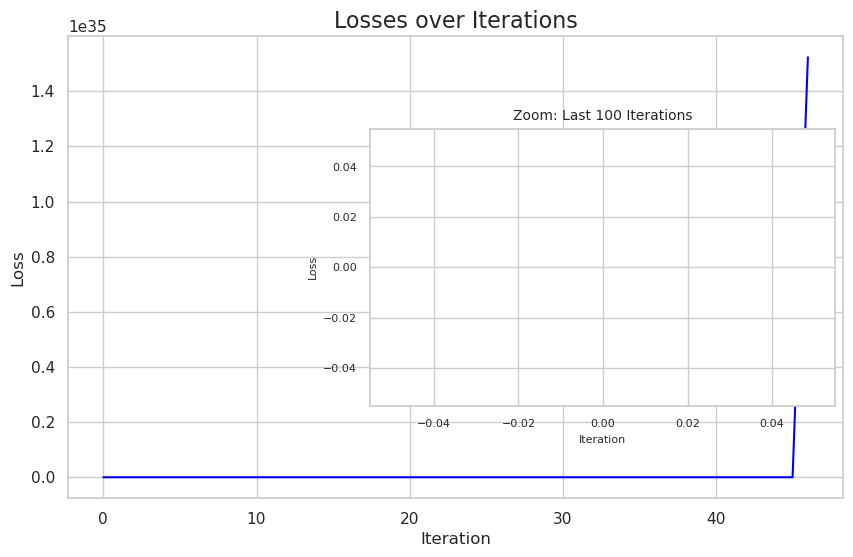

In [5]:
# Data from results GPD
num_iterations = results_GEV["svi_metadata"]["num_iterations"]
losses = results_GEV["losses"]

sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x=range(num_iterations), y=losses, ax=ax, color="blue")

ax.set_title("Losses over Iterations", fontsize=16)
ax.set_xlabel("Iteration", fontsize=12)
ax.set_ylabel("Loss", fontsize=12)

ax_inset = inset_axes(ax, width="60%", height="60%", loc="center right")
sns.lineplot(
    x=range(num_iterations - 100, num_iterations),
    y=losses[-100:],
    ax=ax_inset,
    color="orange",
)
ax_inset.set_title("Zoom: Last 100 Iterations", fontsize=10)
ax_inset.set_xlabel("Iteration", fontsize=8)
ax_inset.set_ylabel("Loss", fontsize=8)
ax_inset.tick_params(axis="both", which="major", labelsize=8)

#plt.tight_layout()
plt.show()

In [6]:
chol_lower_tril = results_GEV["scale_vi_matrix"]
covariance_matrix_jnp = jnp.dot(chol_lower_tril, chol_lower_tril.T)
diagonal = jnp.diag(covariance_matrix_jnp)
diagonal

Array([nan, nan, nan, nan, nan, nan], dtype=float32)

In [7]:
results_GEV["transformed_loc_vi_parameters"]

{'betas_loc': Array([nan, nan], dtype=float32),
 'betas_scale': Array([nan, nan], dtype=float32),
 'betas_shape': Array([nan, nan], dtype=float32)}

<Figure size 1200x700 with 0 Axes>

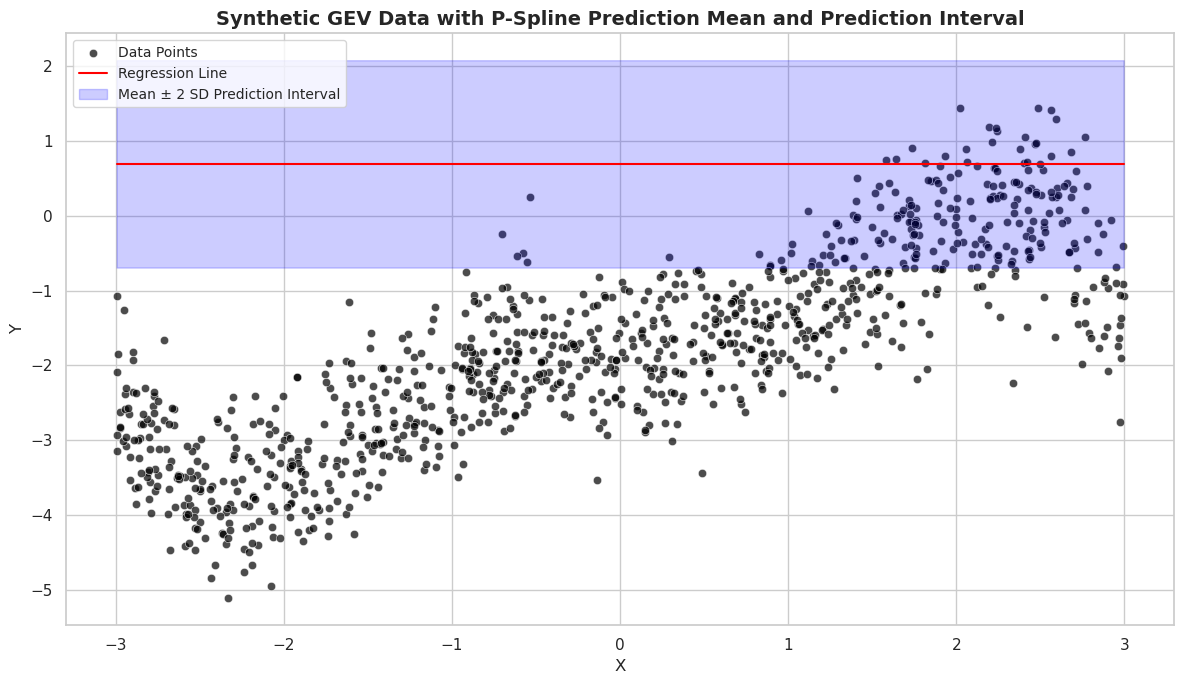

In [10]:
# Response is GPD GAMLSS Distributed Case
betas_loc = results_GEV["transformed_loc_vi_parameters"]["betas_loc"]
betas_scale = results_GEV["transformed_loc_vi_parameters"]["betas_scale"]
betas_shape = results_GEV["transformed_loc_vi_parameters"]["betas_shape"]

X_min, X_max = X_GEV.min(), X_GEV.max()
X_line = np.linspace(X_min, X_max, 1000)
X_line_design = DataPreperator(
    "xDesign",
    X_line,
    "identity",
    intercept=True,
    standardize=True,
)()
linear_predictor_loc = X_line_design.matrix @ betas_loc
linear_predictor_scale = TransformationFunctions.softplus(
    X_line_design.matrix @ betas_scale
)
linear_predictor_shape = X_line_design.matrix @ betas_shape

GEV_mean = linear_predictor_loc + (
    linear_predictor_scale / (1 - linear_predictor_shape)
)
GEV_variance = linear_predictor_scale**2 / (
    (1 - linear_predictor_shape) ** 2 * (1 - 2 * linear_predictor_shape)
)
GEV_sd = jnp.sqrt(GEV_variance)

sns.set_style("whitegrid")
sns.set_palette("deep")

plt.figure(figsize=(12, 7))
fig, ax = plt.subplots(figsize=(12, 7))

sns.scatterplot(
    x=np.array(X_GEV), y=np.array(Y_GEV), color="black", label="Data Points", alpha=0.7, ax=ax
)

# Plots the PSpline regression line
sns.lineplot(
    x=X_line, y=GEV_mean, color="red", label="Regression Line", ax=ax
)

# Calculate the standard deviation
Y_lower = GEV_mean - 2 * GEV_sd
Y_upper = GEV_mean + 2 * GEV_sd

# Add the two standard deviation interval
ax.fill_between(
    X_line,
    Y_lower,
    Y_upper,
    color="blue",
    alpha=0.2,
    label="Mean ± 2 SD Prediction Interval",
)

ax.legend(fontsize=10, loc="upper left")

ax.set_xlabel("X", fontsize=12)
ax.set_ylabel("Y", fontsize=12)
ax.set_title(
    "Synthetic GEV Data with P-Spline Prediction Mean and Prediction Interval",
    fontsize=14,
    fontweight="bold",
)

plt.tight_layout()

plt.show()

<Figure size 1200x700 with 0 Axes>

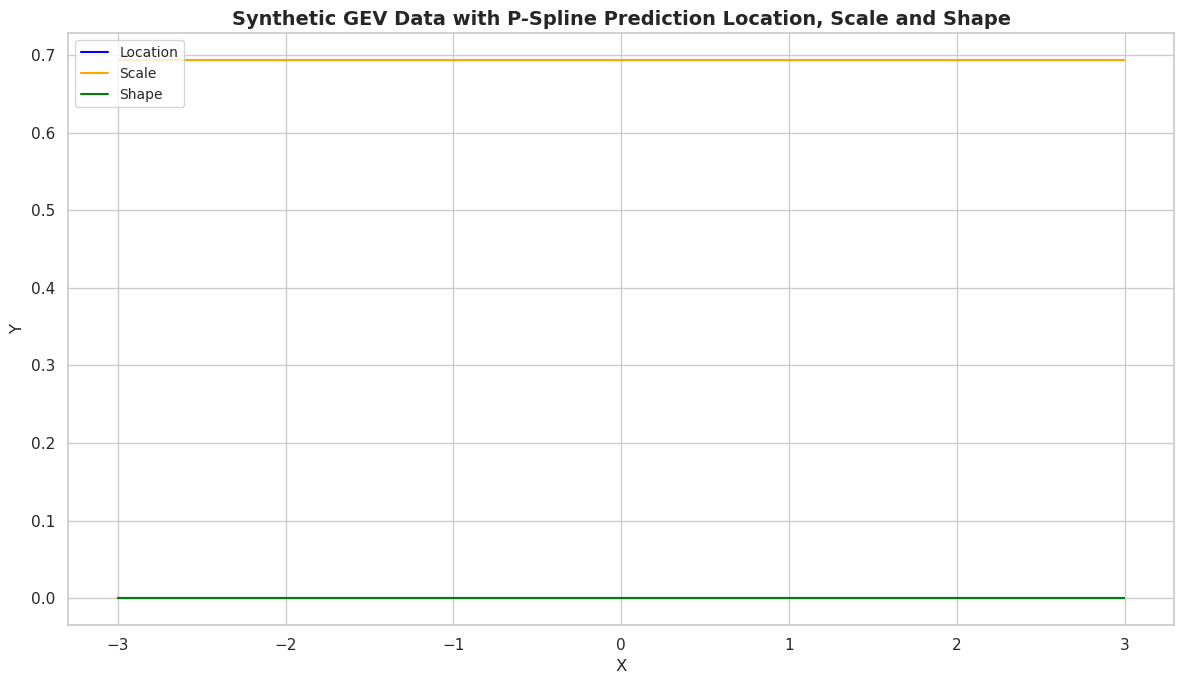

In [11]:
# plot location scale shape predicted curves
plt.figure(figsize=(12, 7))
fig, ax = plt.subplots(figsize=(12, 7))

# Plot the PSpline regression line
sns.lineplot(x=X_line, y=linear_predictor_loc, color="blue", label="Location", ax=ax)
sns.lineplot(x=X_line, y=linear_predictor_scale, color="orange", label="Scale", ax=ax)
sns.lineplot(x=X_line, y=linear_predictor_shape, color="green", label="Shape", ax=ax)

# Improve the legend
ax.legend(fontsize=10, loc="upper left")

# Customize the plot
ax.set_xlabel("X", fontsize=12)
ax.set_ylabel("Y", fontsize=12)
ax.set_title(
    "Synthetic GEV Data with P-Spline Prediction Location, Scale and Shape",
    fontsize=14,
    fontweight="bold",
)

# Adjust the plot margins
plt.tight_layout()

# Show the plot
plt.show()

## GPD

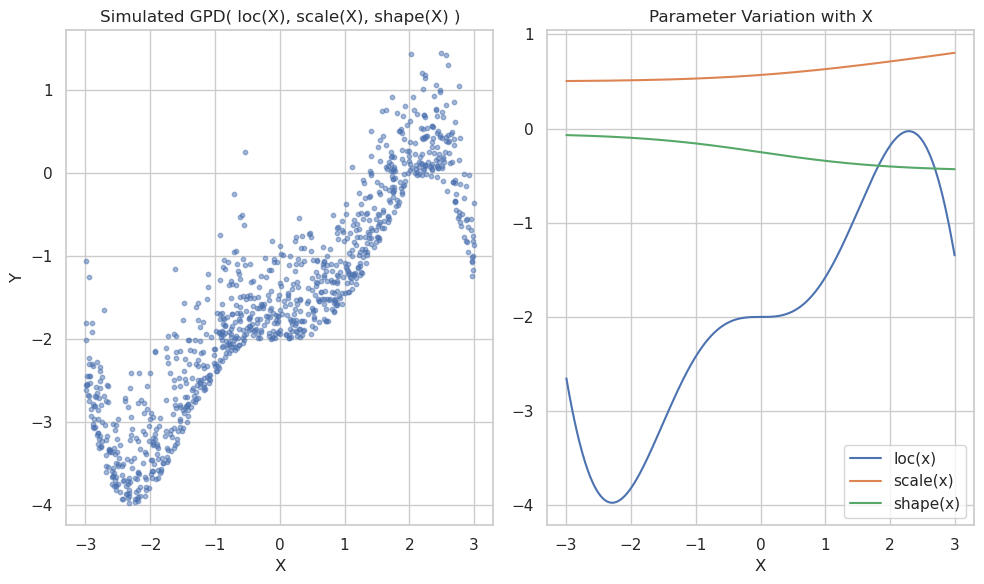

In [12]:
import jax
import jax.numpy as jnp
import tensorflow_probability as tfp
tfd = tfp.distributions
import matplotlib.pyplot as plt

# ------------------------------------------------
# 1) Generate covariate X
# ------------------------------------------------
key = jax.random.PRNGKey(42)
n_samples = 1000
key_x, key_y = jax.random.split(key)
X_GPD = jax.random.uniform(key_x, shape=(n_samples,), minval=-3.0, maxval=3.0)

# ------------------------------------------------
# 2) Define parametric functions for loc(x), scale(x), shape(x)
# ------------------------------------------------

def loc_fn(x):
    """
    Location can be any real number. 
    For example: loc(x) = 0.2 * x^2 * sin(x) - 2
    """
    return 0.5 * x**2 * jnp.sin(x) - 2 

def scale_fn(x):
    """
    Scale must be strictly positive. 
    Uses softplus to ensure positivity.
    Let's do scale(x) = 1 + softplus(0.2*x).
    This will remain > 1.0 for large x and approach 1.0 for negative x.
    """
    return .5 + TransformationFunctions.softplus(x) * 0.1

def shape_fn(x):
    """
    Shape can be any real number. 
    We'll use a scaled tanh() so it transitions from negative to positive.
    For example, shape(x) = 0.3 * tanh(0.5*x).
    This yields shape in (-0.3, 0.3).
    """
    return -0.2 * jnp.tanh(0.5 * x) - 0.25

# Vectorize param values for each sample
loc_vals   = loc_fn(X_GPD)
scale_vals = scale_fn(X_GPD)
shape_vals = shape_fn(X_GPD)

# ------------------------------------------------
# 3) Construct a *batch* of GPDs, one per (x_i).
#    TFP automatically enforces domain logic for each sample.
# ------------------------------------------------
gpd_dists = tfd.GeneralizedPareto(
    loc          = loc_vals,     # shape=(n_samples,)
    scale        = scale_vals,   # shape=(n_samples,)
    concentration= shape_vals    # shape=(n_samples,)
)

# ------------------------------------------------
# 4) Sample Y given X
# ------------------------------------------------
Y_GPD_tf = gpd_dists.sample(seed=key_y)  # shape=(n_samples,)
Y_GPD = jnp.array(Y_GPD_tf)

# ------------------------------------------------
# 5) Optional: Visualization
# ------------------------------------------------
plt.figure(figsize=(10,6))

# Plot the (X, Y) cloud
plt.subplot(1,2,1)
plt.scatter(X_GPD, Y_GPD, alpha=0.5, s=10)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Simulated GPD( loc(X), scale(X), shape(X) )")

# Plot how each parameter depends on X
xs_sorted = jnp.sort(X_GPD)
loc_sorted = loc_fn(xs_sorted)
scale_sorted = scale_fn(xs_sorted)
shape_sorted = shape_fn(xs_sorted)

plt.subplot(1,2,2)
plt.plot(xs_sorted, loc_sorted, label="loc(x)")
plt.plot(xs_sorted, scale_sorted, label="scale(x)")
plt.plot(xs_sorted, shape_sorted, label="shape(x)")
plt.xlabel("X")
plt.title("Parameter Variation with X")
plt.legend()
plt.tight_layout()
plt.show()

In [30]:
XDesignGPD = DataPreperator(
    "xDesign",
    X_GPD,
    "identity",
    intercept=True,
    standardize=True,
)()
ncols = XDesignGPD.matrix.shape[1]

betas_loc_GPD = Normal("betas_loc", jnp.array([0.0,0.0]), jnp.array([1.0,1.0])*100, ncols)
betas_scale_GPD = Normal("betas_scale", jnp.array([0.0,0.0]), jnp.array([1.0,1.0])*100, ncols)
betas_shape_GPD = Normal("betas_shape", jnp.array([0.0,0.0]), jnp.array([1.0,1.0])*100, ncols)
y_GPD = CustomGEV(
    "y",
    XDesignGPD @ betas_loc_GPD,
    XDesignGPD @ betas_scale_GPD,
    XDesignGPD @ betas_shape_GPD,
    responses=Y_GPD,
)
results_GPD = y_GPD.model.run_svi_optimization(
    optimizer=adam,
    vi_dist=FullCovarianceNormal,
    vi_sample_size=64,
    epochs=10,
    mb_size=32,
    lr=0.001,
    max_norm=5.0,
    clip_min_max_enabled=True,
    zero_nans_enabled=True,
    prng_key=PRNGKey(0),
)

log_joint_pdfs:  (Traced<ConcreteArray([-11.048234], dtype=float32)>with<JVPTrace(level=2/0)> with
  primal = Array([-11.048234], dtype=float32)
  tangent = Traced<ShapedArray(float32[1])>with<JaxprTrace(level=1/0)> with
    pval = (ShapedArray(float32[1]), None)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7ee51ab68650>, in_tracers=(Traced<ShapedArray(float32[1,2]):JaxprTrace(level=1/0)>,), out_tracer_refs=[<weakref at 0x7ee51b5a8cc0; to 'JaxprTracer' at 0x7ee526bc8bd0>], out_avals=[ShapedArray(float32[1])], primitive=reduce_sum, params={'axes': (1,)}, effects=frozenset(), source_info=<jax._src.source_info_util.SourceInfo object at 0x7ee51ab6e230>, ctx=JaxprEqnContext(compute_type=None,threefry_partitionable=False),xla_metadata={}), Traced<ConcreteArray([-11.048243], dtype=float32)>with<JVPTrace(level=2/0)> with
  primal = Array([-11.048243], dtype=float32)
  tangent = Traced<ShapedArray(float32[1])>with<JaxprTrace(level=1/0)> with
    pval = (ShapedArray(float32[1]), None)


ValueError: All arrays must be of the same length

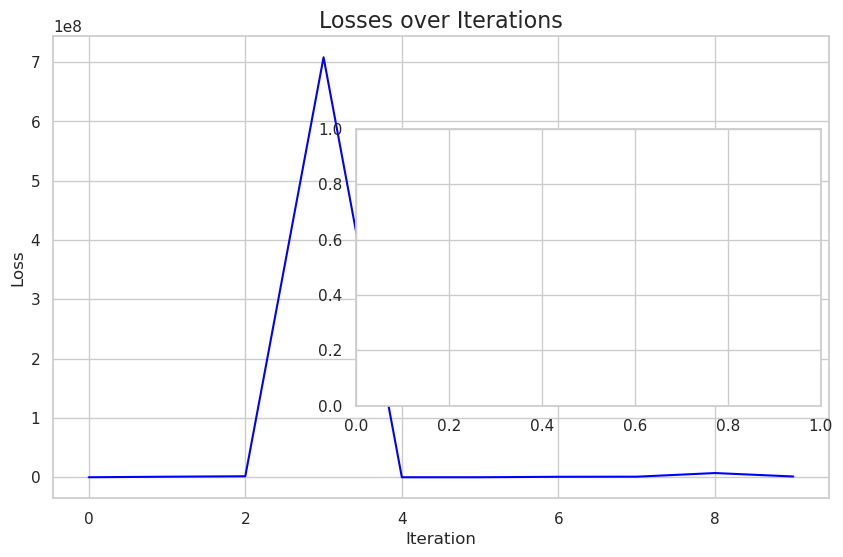

In [32]:
# Data from results GPD
num_iterations = results_GPD["svi_metadata"]["num_iterations"]
losses = results_GPD["losses"]

sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x=range(num_iterations), y=losses, ax=ax, color="blue")

ax.set_title("Losses over Iterations", fontsize=16)
ax.set_xlabel("Iteration", fontsize=12)
ax.set_ylabel("Loss", fontsize=12)

ax_inset = inset_axes(ax, width="60%", height="60%", loc="center right")
sns.lineplot(
    x=range(num_iterations - 100, num_iterations),
    y=losses[-100:],
    ax=ax_inset,
    color="orange",
)
ax_inset.set_title("Zoom: Last 100 Iterations", fontsize=10)
ax_inset.set_xlabel("Iteration", fontsize=8)
ax_inset.set_ylabel("Loss", fontsize=8)
ax_inset.tick_params(axis="both", which="major", labelsize=8)

#plt.tight_layout()
plt.show()